In [1]:
from astropy.io import fits
from astropy import table
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
import numpy as np
from uuid import uuid4

from urllib.request import urlopen
from urllib.parse import quote
import json

import csv

import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
def getUUID(s=12):
    return int(str(uuid4().int)[:s])

Useful SDSS query commands
---

Photo primary table (most info on the galactic hosts will be here):
https://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoPrimary+V

Spectrum table:
https://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+SpecObj+V

In [3]:
# ----- Riding through the SQL storm ----- 


# -- Gets host information given an RA, DEC --

dr = 14
sqlSearchUrl = "http://skyserver.sdss.org/dr{}/SkyServerWS/SearchTools/SqlSearch?".format(dr)

def convertNoneValsTo0(hostDict):
    return {k: 0 if hostDict[k]==None else hostDict[k] for k in hostDict}

def getSQLSearchCommandUrl(command):
    urlCmd = quote(command)
    args = "cmd={}&limit=0".format(urlCmd)
    url = sqlSearchUrl + args
    return url

def processResponse(response):
    responseReadout = response.read()
    responseObject = json.loads(responseReadout.decode("utf-8"))
    hostsList = responseObject[0]['Rows'] # Extracts the dictionary of hosts info
    hostsList = list(map(convertNoneValsTo0, hostsList))
    return hostsList

# -- SQL commands for searches --

def getNearestHostsCommand(ra, dec, arcsecLimit, numLimit):
    arcminLimit = arcsecLimit / 60
    return (
        "SELECT TOP {}"
        "  p.objid, p.specobjid, p.ra, p.dec"
        ", p.u, p.g, p.r, p.i, p.z"
        ", p.err_u, p.err_g, p.err_r, p.err_i, p.err_z"
        ", n.distance AS offset"
        ", pz.z AS redshift, pz.zErr AS redshift_err"
        ", p.expRad_r"
        " FROM fGetNearbyObjEq({},{},{}) n"
        " JOIN PhotoPrimary p ON n.objID=p.objID"
        " LEFT JOIN Photoz pz ON pz.objID=p.objID"
        " ORDER BY offset"
    ).format(numLimit, ra, dec, arcminLimit)

def getNearestSpectrumInfoCommand(ra, dec, arcsecLimit):
    arcminLimit = arcsecLimit / 60
    return (
        "SELECT"
        "  s.specObjID, s.ra, s.dec, n.distance AS offset"
        ", s.class, s.subclass"
        ", s.z AS redshift, s.zErr AS redshift_err"
        ", s.velDisp, s.velDispErr"
        ", s.plate, s.mjd, s.fiberID" # These three are needed to get the actual spectrum
        " FROM fGetNearbySpecObjEq({},{},{}) n"
        " JOIN SpecObj s ON n.specObjID=s.specObjID"
        " ORDER BY offset"
    ).format(ra, dec, arcminLimit)

# -- Specific search functions --

def searchSQL(sqlCommand):
    url = getSQLSearchCommandUrl(sqlCommand)
    response = urlopen(url)
    return processResponse(response)

def searchNearestHosts(ra, dec, radius, num):
    command = getNearestHostsCommand(ra, dec, radius, num)
    return searchSQL(command)
                       
def getNearestHost(ra, dec, radius):
    hostList = searchNearestHosts(ra, dec, radius, 1)
    if len(hostList) == 0: return None
    return hostList[0]

def getNearestSpectraInfo(ra, dec, radius):
    command = getNearestSpectrumInfoCommand(ra, dec, radius)
    return searchSQL(command)


In [4]:
getNearestSpectraInfo(315.90303127, -1.22853775, 1)

[{'specObjID': 1109090338984716288,
  'ra': 315.903,
  'dec': -1.2285646,
  'offset': 0.00247261586638966,
  'class': 'GALAXY',
  'subclass': 'STARFORMING',
  'redshift': 0.0645438,
  'redshift_err': 7.137781e-06,
  'velDisp': 133.1707,
  'velDispErr': 39.50918,
  'plate': 985,
  'mjd': 52431,
  'fiberID': 287}]

In [5]:
# -- Get spectra in a region given RA, DEC --

def getSpectrum(specInfo):
    spectra = SDSS.get_spectra(plate=specInfo['plate'], mjd=specInfo['mjd'], fiberID=specInfo['fiberID'])
    if len(spectra) == 0: return None
    return spectra[0]

# def getHostSpectra(hostInfo, galacticRadiusLimit):
#     hostRa, hostDec = hostInfo['ra'], hostInfo['dec']
#     hostCoord = coords.SkyCoord(hostRa * u.deg, hostDec * u.deg)
#     print("hostCoord", hostCoord)
#     radiusLimit = galacticRadiusLimit * hostInfo['expRad_r']
#     print(radiusLimit * u.arcsec)
#     return SDSS.get_spectra(coordinates = hostCoord, radius = radiusLimit * u.arcsec)

In [6]:
getSpectrum(specInfo)

NameError: name 'specInfo' is not defined

In [204]:
catFile = 'catalogs/clumpy_stripe82_fullsample.fits'
catFits = fits.open(catFile) 
catTable = table.Table(catFits[1].data)

Creates the actual spectrum catalog
---

In [315]:
def getSpectrumFilename(galId, spectrumIndex):
    return '{}_{}.fits'.format(galId, spectrumIndex)

def getAngleDistance(raDec1, raDec2):
    ra1, dec1 = raDec1
    ra2, dec2 = raDec2
    return \
        coords.SkyCoord(ra1 * u.deg, dec1 * u.deg) \
        .separation(coords.SkyCoord(ra2 * u.deg, dec2 * u.deg)) \
        .to(u.arcsec).value

# Returns the distance between the spectrum and the host galaxy in galactic radii
def getSpectrumGalaxyDistance(hostInfo, spectrum):
    specRaDec = (specInfo['ra'], specInfo['dec'])
    hostRaDec = (hostInfo['ra'], hostInfo['dec'])
    angleDistance = getAngleDistance(specRaDec, hostRaDec)
    
    hostRadius = hostInfo['expRad_r']
    galaxyDistance = angleDistance / hostRadius
    
    return galaxyDistance
    
# -- Structure of a row in the catalog --    

# This is where we want to start thinking about what info we want to save from the spectrum

def getEmptyRowDict():
    return {
        'galaxy_id': None,
        'spectrum_index': None,
        'filename': None,
        'gal_ra': None,
        'gal_dec': None,
        'gal_redshift': None,
        'gal_redshift_err': None,
        'gal_radius': None,
        'spec_ra': None,
        'spec_dec': None,
        'spec_distance': None,
        'spec_redshift': None,
        'spec_redshift_err': None,
        'class': None,
        'subclass': None,
        'vel_disp': None,
        'vel_disp_err': None
    }

fieldnames = list(getEmptyRowDict().keys())

def getSpectrumRowDict(galId, spectrumIndex, hostInfo, specInfo):
    rowDict = getEmptyRowDict()
    rowDict['galaxy_id'] = galId
    rowDict['spectrum_index'] = spectrumIndex
    rowDict['filename'] = getSpectrumFilename(galId, spectrumIndex)
    rowDict['gal_ra'] = hostInfo['ra']
    rowDict['gal_dec'] = hostInfo['dec']
    rowDict['gal_redshift'] = hostInfo['redshift']
    rowDict['gal_redshift_err'] = hostInfo['redshift_err']
    rowDict['gal_radius'] = hostInfo['expRad_r']
    rowDict['spec_ra'] = specInfo['ra']
    rowDict['spec_dec'] = specInfo['dec']
    rowDict['spec_distance'] = getSpectrumGalaxyDistance(hostInfo, specInfo)
    rowDict['spec_redshift'] = specInfo['redshift']
    rowDict['spec_redshift_err'] = specInfo['redshift_err']
    rowDict['class'] = specInfo['class']
    rowDict['subclass'] = specInfo['subclass']
    rowDict['vel_disp'] = specInfo['velDisp']
    rowDict['vel_disp_err'] = specInfo['velDispErr']
    return rowDict

TODO: Run the below cell on the whole catalog

In [316]:
galacticRadiusLimit = 10

spectraDir = 'spectra_sdss/'

catalogFilename = spectraDir + 'catalog.csv'

with open(catalogFilename, 'w') as catalogFile:
    writer = csv.DictWriter(catalogFile, fieldnames)
    writer.writeheader()

    print("Total", len(catTable))
    count = 1;
    for row in catTable[:3]:
        try:
            print()
            print('Galaxy:', count)
            count += 1

            arcsecToSearch = 1
            hostInfo = getNearestHost(row['RA'], row['DEC'], arcsecToSearch)
            print('Galaxy info:', hostInfo)

            hostRadius = hostInfo['expRad_r']
            radiusLimit = galacticRadiusLimit * hostRadius
            specInfoList = getNearestSpectraInfo(hostInfo['ra'], hostInfo['dec'], radiusLimit)

            galId = hostInfo['objid']

            print('Writing spectra to catalog...')
            for spectrumIndex in range(len(specInfoList)):
                print('\tSpec', spectrumIndex)

                specInfo = specInfoList[spectrumIndex]
                spectrum = getSpectrum(specInfo)

                filename = getSpectrumFilename(galId, spectrumIndex)

                # Saves the spectrum file
                spectrum.writeto(spectraDir + filename, overwrite=True)

                # Saves the info about the spectrum
                csvRow = getSpectrumRowDict(galId, spectrumIndex, hostInfo, specInfo)
                writer.writerow(csvRow)
            except Exception as e:
                print("Failed to write")
                print(type(e))
                print(e)


Total 281

Galaxy: 1
Galaxy info: {'objid': 1237656567039787633, 'specobjid': 1109090338984716288, 'ra': 315.903027033787, 'dec': -1.22852938693264, 'u': 18.93229, 'g': 17.5829, 'r': 17.25282, 'i': 17.00515, 'z': 16.99127, 'err_u': 0.1025007, 'err_g': 0.009931025, 'err_r': 0.009251588, 'err_i': 0.01361759, 'err_z': 0.0377005, 'offset': 0.000562460057429133, 'redshift': 0.043284, 'redshift_err': 0.015217, 'expRad_r': 3.411275}
Writing spectra to catalog...
	Spec 0

Galaxy: 2
Galaxy info: {'objid': 1237656567042343485, 'specobjid': 1112474362390276096, 'ra': 321.637909591718, 'dec': -1.12279996353434, 'u': 22.14544, 'g': 18.89027, 'r': 17.51433, 'i': 17.05244, 'z': 16.61683, 'err_u': 0.5355909, 'err_g': 0.01648477, 'err_r': 0.007732976, 'err_i': 0.007604408, 'err_z': 0.01759662, 'offset': 0.000377096800907386, 'redshift': 0.202843, 'redshift_err': 0.018906, 'expRad_r': 1.449321}
Writing spectra to catalog...
	Spec 0

Galaxy: 3
Galaxy info: {'objid': 1237663456705970284, 'specobjid': 1114

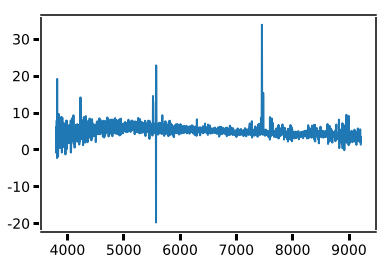

324.02026 -0.025889


In [271]:
specData = table.Table(spectrum[1].data)
plt.plot(10**specData['loglam'], specData['flux'])
plt.show()
print(spectrum[0].header['RA'], spectrum[0].header['DEC'])

{'specObjID': 4723324198390308864,
 'ra': 324.00902,
 'dec': 0.0022094895,
 'offset': 1.81579341757762,
 'class': 'GALAXY',
 'subclass': '',
 'redshift': 0.4860547,
 'redshift_err': 0.0001126065,
 'velDisp': 196.4215,
 'velDispErr': 28.41779,
 'plate': 4195,
 'mjd': 55452,
 'fiberID': 633}